## Part 0: Setting things up -- libraries and functions

### Loading needed libraries

In [ ]:
from deep_rl import *
import matplotlib.pyplot as plt
import torch
from tqdm import trange, tqdm
import random
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

### Plotting functions

In [2]:
### Plotting the results
def convolve(points, kernelSize=5):
    array = np.convolve(points, np.ones(kernelSize)/kernelSize, 'valid')
    return array

def plot_dqn(obj, title = 'DQN'):
    plt.figure(figsize=(12,12),dpi=100)
    plt.subplot(311)
    plt.plot(convolve(obj.loss_vec, kernelSize=11)/11)
    plt.title(title+' loss ')
    plt.ylabel('loss value'), plt.xlabel('batch no')
    plt.subplot(312)
    plt.plot(convolve(obj.loss_vec, kernelSize=111)/111)
    plt.title(title+' smoothed loss ')
    plt.ylabel('loss value'), plt.xlabel('batch no')
    plt.subplot(313)
    plt.plot(np.array(obj.returns)[:,0],np.array(obj.returns)[:,1])
    plt.xlabel('timesteps'), plt.ylabel('return')
    plt.title(title+' training performance')
    plt.show()

def plot_dsr(obj, title='DSR'):
    plt.figure(figsize=(12,12),dpi=100)
    plt.subplot(211)
    plt.plot(convolve(obj.loss_q_vec, kernelSize=111))
    plt.title(title+' loss')
    plt.ylabel('loss q value'), plt.xlabel('batch no')
    plt.subplot(212)
    plt.plot(convolve(obj.loss_psi_vec, kernelSize=111))
    plt.title(title+' loss')
    plt.ylabel('loss psi value'), plt.xlabel('batch no')
    
def plot_dsr2(obj, title='DSR'):
    plt.figure(figsize=(12,4),dpi=100)
    plt.plot(convolve(obj.loss_psi_vec, kernelSize=11)/11)
    plt.title(title+' loss')
    plt.ylabel('loss psi value'), plt.xlabel('batch no')
    
def params_count(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    return sum([np.prod(p.size()) for p in model_parameters])

### Sanity check functions

In [7]:
env.reset()

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])

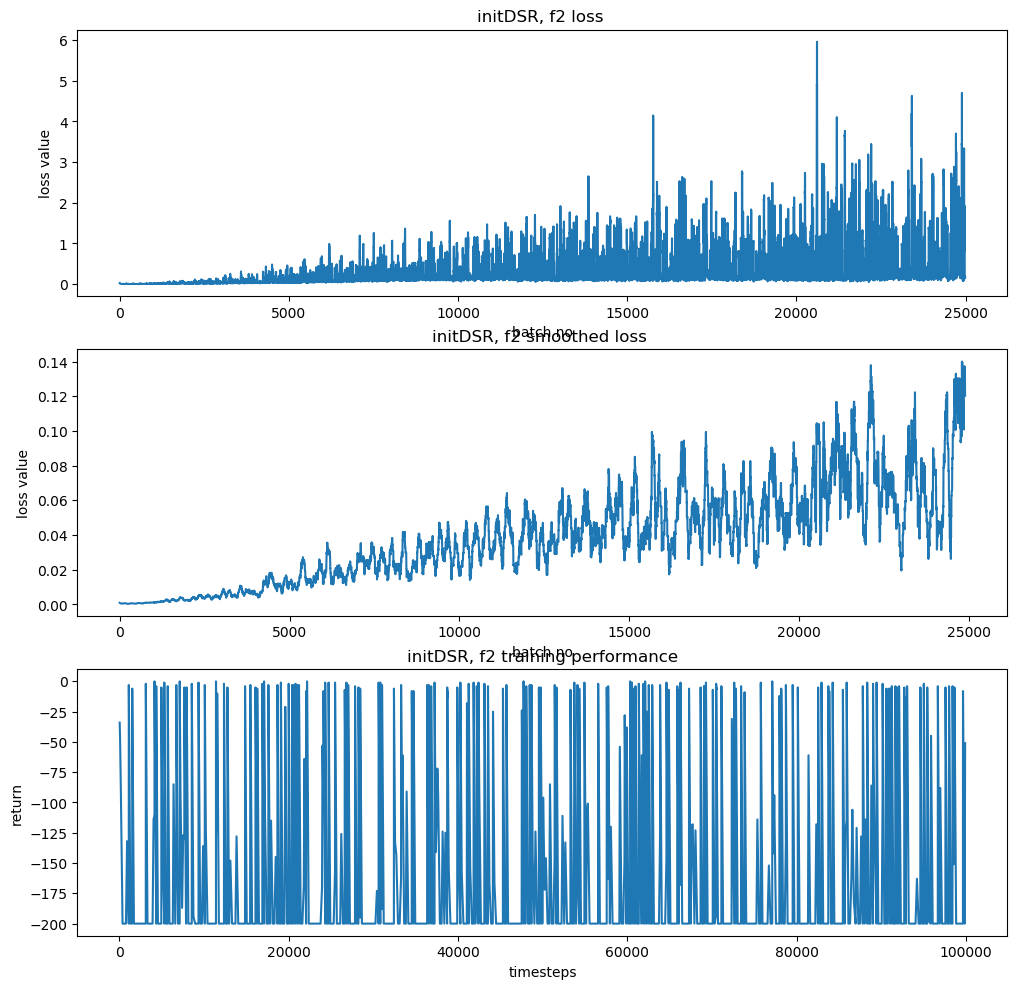

In [41]:
from deep_rl.component.fourrooms import FourRooms
env = FourRooms(goal=9)

def _visualize_vector(vector, title="unnamed", show_goal=False, show=True, label=None):
    """Function to visualize vector of size 104"""
    
    current_grid = np.array(env.occupancy, dtype=np.float) # 1 - walls, 0 - 
    for i in range(104):
    #     if(vals[i]>0):
    #         import pdb; pdb.set_trace()
        p_cell = env.tocell[i]
        current_grid[p_cell[0], p_cell[1]] = vector[i]

        if show_goal:
            goal_cell = env.tocell[env.goal]
            current_grid[goal_cell[0], goal_cell[1]] = -1
        
    plt.imshow(current_grid), plt.colorbar()
    plt.title(title)
    if show:
        plt.show()
        
def sanity(agent, is_dsr=True, title="unnamed"):
    
    print(agent.network)
    plt.figure(figsize=(10,10))
    
    # Setting things up
    env = FourRooms(goal=9)
    
    # Visualize w
    if(is_dsr):
        plt.subplot(221)
        w_vector = agent.network.state_dict()['psi2q.w'].numpy()
        _visualize_vector(w_vector, title=title+" w learnt values", show=False)
    
    # Visualize psi
    if(is_dsr):
        plt.subplot(222)
        states = [100]
#         plt.figure(figsize=(len(states)*12, 5))

        for i, s in enumerate(states):
            temp = np.zeros(104)
            temp[s] = 1
            phi, psi, q = agent.network(tensor(temp).unsqueeze(0))
            psi = psi.detach().numpy()
            optimal_actions = q.max(1)[1].detach().numpy()
            psi = psi[:, optimal_actions, :]
            q = q.detach().numpy().flatten()
#             _visualize_vector(psi[:,0,:].flatten(), title=title+" q({},{})={}".format(s, 0, q[0]), show=False, label="0")
            _visualize_vector(psi.flatten(), title=title+" psi*, s = {}".format(s), show=False, label="1")
            
    # Visualize policy
    state_space = np.identity(104)
    if(is_dsr):
        
        phi, psi, q = agent.network(tensor(state_space))
    else:
        q = agent.network(tensor(state_space))
    
#     print('Qvalue estiamtes: ', q.detach().numpy())
    plt.subplot(223)
    optimal_actions = q.max(1)[1].detach().numpy()
#     import pdb; pdb.set_trace()
    _visualize_vector(optimal_actions, title=title+'policy (0:up,1:down,2:left,3:right)', show=False)
#     plt.show()
    plt.subplot(224)
    # Visualize Q*
    _visualize_vector(q.max(1)[0].detach().numpy(), title=title+' Q* estimates')
  
# sanity(initdsr2, is_dsr=True, title='initDSR, f2')
plot_dqn(initdsr2, title='initDSR, f2')
# dsr1 = dsr2
# print(dsr1.loss_psi_vec[:10],dsr1.loss_q_vec[:10])
# print(dsr1.loss_psi_vec[-10:],dsr1.loss_q_vec[-10:])

(104, 2)


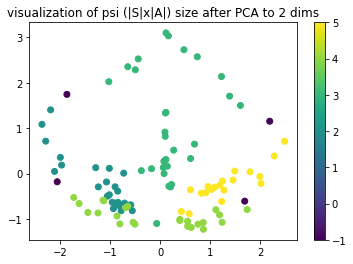

In [68]:
from sklearn.decomposition import PCA

def dimenRed(vis_agent):
    """
    Function to reduce the dimensionality of the psi(s,a) representations learnt,
    and visualizing them.
    """
    state_space = np.identity(104)
    c = np.ones(104)*5
    room1 = list(range(5)) + list(range(10,15)) + list(range(20,25)) + list(range(31,36)) +list(range(41,46))
    room2 = list(range(5,10)) + list(range(15,20)) + list(range(26,31)) + list(range(36,41)) + list(range(46,51)) + list(range(52,57))
    room3 = list(range(57,62)) + list(range(63,68)) + list(range(73,78)) + list(range(83,88)) + list(range(94,99))
    connect = [25, 51, 62, 88]
    c[room1] = 2
    c[room2] = 3
    c[room3] = 4
    c[connect] = -1
    
    _, psi, _ = vis_agent.network(tensor(state_space))
    psi = psi.view(104,-1).detach().numpy()
    pca = PCA(n_components=2)
    k = pca.fit_transform(psi)
    print(k.shape)
    plt.scatter(k[:,0],k[:,1],c=c)
    plt.colorbar()
    plt.title('visualization of psi (|S|x|A|) size after PCA to 2 dims')
    
    
def dimenRed2(vis_agent, act_agent):
    """
    Function to reduce the dimensionality of the psi* representations learnt,
    and visualizing them.
    NOTE: psi*, where are the optimal actions picked from matters. act_agent 
    is used here.
    """
    state_space = np.identity(104)
    
    _, psi, _ = vis_agent.network(tensor(state_space))
    
    if('DSR' in str(type(act_agent))):
        _, _, q = act_agent.network(tensor(state_space))
    else:
        q = act_agent.network(tensor(state_space))
    optimal_actions = q.max(1)[1].detach().numpy()
    
    pass

dimenRed(avdsr)

True

### DSR training function

In [23]:
def dsr_feature(**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.c = 1
#     config.freeze = False

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.001)
    config.network_fn = lambda: SRNet(config.action_dim, SRIdentityBody(config.state_dim), hidden_units=())
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e4), batch_size=10)

    config.random_action_prob = LinearSchedule(1, 0.1, 5e4)
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = 5e4
    config.async_actor = False
    
    # Train an agent with the above config
    agent = DSRAgent(config)
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    while True:
        if config.save_interval and not agent.total_steps % config.save_interval:
            agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
        if config.log_interval and not agent.total_steps % config.log_interval:
#             agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.eval_interval and not agent.total_steps % config.eval_interval:
            agent.eval_episodes()
            pass
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
        agent.step()
        agent.switch_task()
        
    return agent

### DQN training function

In [3]:
def dqn_feature(**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.001)
    config.network_fn = lambda: VanillaNet(config.action_dim, FCBody(config.state_dim, hidden_units=(64,32)))
    # config.network_fn = lambda: DuelingNet(config.action_dim, FCBody(config.state_dim))
    # config.replay_fn = lambda: Replay(memory_size=int(1e4), batch_size=10)
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e4), batch_size=10)

    config.random_action_prob = LinearSchedule(1.0, 0.1, 1e4)
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = 1e5
    config.async_actor = False
    agent = DQNAgent(config)
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    while True:
        if config.save_interval and not agent.total_steps % config.save_interval:
            agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
        if config.log_interval and not agent.total_steps % config.log_interval:
#             agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.eval_interval and not agent.total_steps % config.eval_interval:
            agent.eval_episodes()
            pass
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
#         import pdb; pdb.set_trace()
        agent.step()
        agent.switch_task()
    return agent

## Part 1: Run basic DSR and DQN to confirm they learn the task

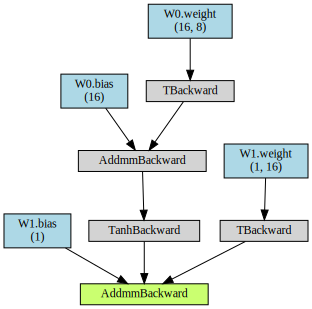

In [88]:
import torch
from torch import nn
from torchviz import make_dot, make_dot_from_trace

model = nn.Sequential()
model.add_module('W0', nn.Linear(8, 16))
model.add_module('tanh', nn.Tanh())
model.add_module('W1', nn.Linear(16, 1))

x = torch.randn(1,8)

make_dot(model(x), params=dict(model.named_parameters()))

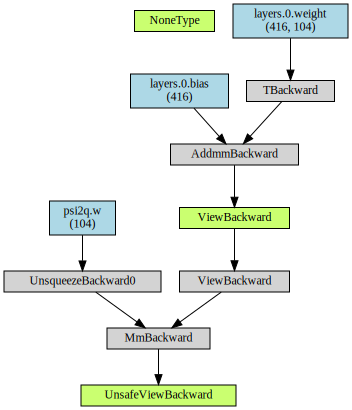

In [84]:
from torchviz import make_dot
x = torch.zeros(10,104)
y = a(x)
make_dot(y, params=dict(a.named_parameters()))

In [92]:
class Psi2QNetFC(nn.Module):
    def __init__(self, output_dim, feature_dim, hidden_units=(), gate=F.relu):
        super(Psi2QNet, self).__init__()

        dims = (body.feature_dim*output_dim,) + hidden_units + (output_dim,)
        self.layers = nn.ModuleList(
            [layer_init_0(nn.Linear(dim_in, dim_out)) for dim_in, dim_out in zip(dims[:-1], dims[1:])])
        self.gate = gate
    
    def forward(self, psi):
        out = psi.view(psi.size(0), -1)
        for layer in self.layers[:-1]:
            out = self.gate(layer(out))
        out = self.layers[-1](out)
        return out

class SRNet(nn.Module):
    """
    Added by Surya.
    SR fully connected body network.
    """
    def __init__(self, output_dim, body, hidden_units=(), gate=F.relu):
        super(SRNet, self).__init__()
        self.body = body
        self.output_dim = output_dim# TODO: check if this is the right way to do it
        dims = (body.feature_dim,) + hidden_units + (body.feature_dim * output_dim,)
        self.layers = nn.ModuleList(
            [layer_init_0(nn.Linear(dim_in, dim_out)) for dim_in, dim_out in zip(dims[:-1], dims[1:])])
        
        self.gate = gate
        self.feature_dim = body.feature_dim * output_dim
        self.psi2q = Psi2QNet(body.feature_dim, output_dim)

    def forward(self, x):
        phi = self.body(tensor(x)) # shape: b x state_dim
        psi = phi
        for layer in self.layers[:-1]:
            psi = self.gate(layer(psi))
        psi = self.layers[-1](psi)
        psi = psi.view(psi.size(0), self.output_dim, self.body.feature_dim) # shape: b x action_dim x state_dim
        out = self.psi2q(psi)

        return phi, psi, out

In [97]:
a = SRNet(4, SRIdentityBody(104), hidden_units=())
print(list(a.named_parameters()))

TypeError: super(type, obj): obj must be an instance or subtype of type

In [4]:
# dsr1 = dsr_feature(game='FourRooms-Goal-9', freeze=0)
# dsr2 = dsr_feature(game='FourRooms-Goal-9', freeze=1)
dqn = dqn_feature(game='FourRooms-Goal-9')

2020-04-23 02:21:21,121 - root - INFO: steps 0, episodic_return_test -200.00(0.00)
2020-04-23 02:21:25,976 - root - INFO: steps 5000, episodic_return_test -180.00(18.97)
2020-04-23 02:21:30,298 - root - INFO: steps 10000, episodic_return_test -121.50(30.41)
2020-04-23 02:21:34,630 - root - INFO: steps 15000, episodic_return_test -105.40(29.93)
2020-04-23 02:21:38,776 - root - INFO: steps 20000, episodic_return_test -64.20(28.13)
2020-04-23 02:21:43,732 - root - INFO: steps 25000, episodic_return_test -31.00(17.86)
2020-04-23 02:21:48,515 - root - INFO: steps 30000, episodic_return_test -10.60(1.24)
2020-04-23 02:21:53,156 - root - INFO: steps 35000, episodic_return_test -11.20(1.65)
2020-04-23 02:21:57,399 - root - INFO: steps 40000, episodic_return_test -10.80(1.64)
2020-04-23 02:22:01,606 - root - INFO: steps 45000, episodic_return_test -10.70(1.39)
2020-04-23 02:22:05,839 - root - INFO: steps 50000, episodic_return_test -8.10(1.67)
2020-04-23 02:22:10,167 - root - INFO: steps 55000,

In [72]:
len(dqn.returns)

14778

Text(0.5,1,'DQN l')

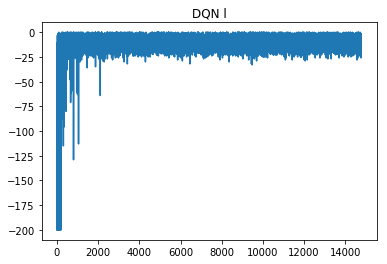

In [69]:
plt.plot(np.array(dqn.returns)[:,1])
plt.title('DQN l')

## Part 2: Train an avSR initialization 

In [18]:
def runNAgents(function, runs, store=False, freeze=0, ref=None):
    r_dqn = []; t_dqn = []
    if(store):
        agents = []
    for i in trange(runs, desc='runs'): 
        agent = function(game='FourRooms-Goal-9', freeze=freeze, ref=ref)
        rewards = np.array(agent.returns)
        t_dqn.append(rewards[:,0])
        r_dqn.append(rewards[:,1])
        if(store):
            agents.append(agent)
            
    if(store):
        return agents, t_dqn, r_dqn
    
    return t_dqn, r_dqn

In [18]:
agents, _, _ = runNAgents(dqn_feature, runs=1, store=True)

runs: 100%|██████████| 1/1 [00:12<00:00, 12.14s/it]


In [5]:
def avdsr_feature(**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.c = 1

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.00025)
    config.network_fn = lambda: SRNet(config.action_dim, SRIdentityBody(config.state_dim))
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e4), batch_size=10)

    config.random_action_prob = LinearSchedule(0.1, 0.1, 1e4) # CHECK
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.max_steps = 1e5
    config.async_actor = False
    
    agent = avDSRAgent(config, config.agents, style='DQN')
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    while True:
        if config.log_interval and not agent.total_steps % config.log_interval:
            agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
        agent.step()
        agent.switch_task()

In [6]:
avdsr = avdsr_feature(game='FourRooms-Goal-9', agents=[dqn])

2020-04-23 02:24:33,500 - root - INFO: steps 0, 85598040.82 steps/s
2020-04-23 02:24:35,133 - root - INFO: steps 1000, 613.11 steps/s
2020-04-23 02:24:36,606 - root - INFO: steps 2000, 679.73 steps/s
2020-04-23 02:24:38,031 - root - INFO: steps 3000, 702.64 steps/s
2020-04-23 02:24:39,430 - root - INFO: steps 4000, 716.14 steps/s
2020-04-23 02:24:40,851 - root - INFO: steps 5000, 704.54 steps/s
2020-04-23 02:24:42,247 - root - INFO: steps 6000, 717.24 steps/s
2020-04-23 02:24:43,653 - root - INFO: steps 7000, 713.44 steps/s
2020-04-23 02:24:45,083 - root - INFO: steps 8000, 699.79 steps/s
2020-04-23 02:24:46,492 - root - INFO: steps 9000, 710.67 steps/s
2020-04-23 02:24:47,908 - root - INFO: steps 10000, 707.23 steps/s
2020-04-23 02:24:49,449 - root - INFO: steps 11000, 649.60 steps/s
2020-04-23 02:24:50,869 - root - INFO: steps 12000, 705.06 steps/s
2020-04-23 02:24:52,632 - root - INFO: steps 13000, 567.54 steps/s
2020-04-23 02:24:54,416 - root - INFO: steps 14000, 560.97 steps/s
202

Text(0.5,1,'unsupervised learning loss does go down')

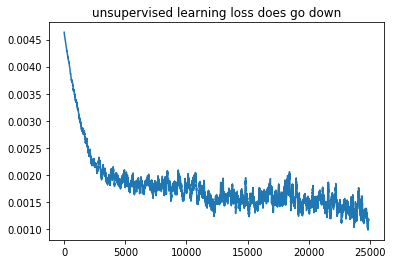

In [8]:
plt.plot(convolve(avdsr.loss_vec, 100))
plt.title('unsupervised learning loss does go down')

In [9]:
sanity(avdsr)

NameError: name 'sanity' is not defined

## Part 3: Train N agents of all styles on same environment and compare results

In [ ]:
# r_dsr1 = runNAgents(dsr_feature, 10, freeze=0)
# r_dsr2 = runNAgents(dsr_feature, 10, freeze=1)
# r_dqn = runNAgents(dqn_feature, 10)
r_avdsr1 = runNAgents(dsr_feature_init, 1, freeze=1, ref=avdsr)
# r_avdsr2 = runNAgents(dsr_feature_init, 10, freeze=1, ref=avdsr)
# r_avdsr3 = runNAgents(dsr_feature_init, 10, freeze=2, ref=avdsr)

In [30]:
initdsr2 = dsr_feature_init(game='FourRooms-Goal-9', ref=avdsr, freeze=2)

2020-04-23 02:48:50,266 - root - INFO: steps 0, episodic_return_test -200.00(0.00)
2020-04-23 02:48:56,248 - root - INFO: steps 5000, episodic_return_test -141.20(28.40)
2020-04-23 02:49:02,130 - root - INFO: steps 10000, episodic_return_test -121.20(30.52)
2020-04-23 02:49:07,898 - root - INFO: steps 15000, episodic_return_test -102.20(30.93)
2020-04-23 02:49:14,189 - root - INFO: steps 20000, episodic_return_test -140.80(28.60)
2020-04-23 02:49:20,430 - root - INFO: steps 25000, episodic_return_test -82.70(30.29)
2020-04-23 02:49:27,137 - root - INFO: steps 30000, episodic_return_test -160.70(24.86)
2020-04-23 02:49:35,112 - root - INFO: steps 35000, episodic_return_test -80.80(30.78)
2020-04-23 02:49:44,620 - root - INFO: steps 40000, episodic_return_test -180.10(18.88)
2020-04-23 02:49:54,582 - root - INFO: steps 45000, episodic_return_test -161.00(24.67)
2020-04-23 02:50:04,945 - root - INFO: steps 50000, episodic_return_test -160.30(25.11)
2020-04-23 02:50:15,304 - root - INFO: s

In [21]:
initdsr1 = dsr_feature_init(game='FourRooms-Goal-9', ref=avdsr, freeze=1)

2020-04-23 02:35:59,623 - root - INFO: steps 0, episodic_return_test -200.00(0.00)
2020-04-23 02:36:06,633 - root - INFO: steps 5000, episodic_return_test -160.40(25.05)
2020-04-23 02:36:13,563 - root - INFO: steps 10000, episodic_return_test -121.20(30.52)
2020-04-23 02:36:20,782 - root - INFO: steps 15000, episodic_return_test -200.00(0.00)
2020-04-23 02:36:28,100 - root - INFO: steps 20000, episodic_return_test -200.00(0.00)
2020-04-23 02:36:36,442 - root - INFO: steps 25000, episodic_return_test -200.00(0.00)
2020-04-23 02:36:45,169 - root - INFO: steps 30000, episodic_return_test -200.00(0.00)
2020-04-23 02:36:55,821 - root - INFO: steps 35000, episodic_return_test -82.20(30.42)
2020-04-23 02:37:06,538 - root - INFO: steps 40000, episodic_return_test -200.00(0.00)
2020-04-23 02:37:15,889 - root - INFO: steps 45000, episodic_return_test -180.50(18.50)
2020-04-23 02:37:25,260 - root - INFO: steps 50000, episodic_return_test -160.90(24.73)
2020-04-23 02:37:35,134 - root - INFO: steps

In [ ]:
sanity(initdsr1)
plot_dqn(initdsr1)

In [16]:
def dsr_feature_init(ref,**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.c = 1

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.001)
    config.network_fn = lambda: SRNet(config.action_dim, SRIdentityBody(config.state_dim))
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e4), batch_size=10)

    config.random_action_prob = LinearSchedule(1.0, 0.1, 1e3)
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = 1e5
    config.async_actor = False
    
    agent = DSRAgent(config)
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    if(ref is not None):
        agent.network.load_state_dict(ref.network.state_dict())
    t0 = time.time()
    while True:
        if config.save_interval and not agent.total_steps % config.save_interval:
            agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
        if config.log_interval and not agent.total_steps % config.log_interval:
#             agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.eval_interval and not agent.total_steps % config.eval_interval:
            agent.eval_episodes()
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
        agent.step()
        agent.switch_task()
        
    return agent

In [ ]:
last1 = runNAgents(dsr_feature_init, 1, freeze=True, ref=agent)

In [123]:
def plot_rewards(rewards, plot_seperate=True , clip=100000, title='unnamed'):
    
    colors = ['red', 'blue', 'green', '#999999', 'm', 'k', 'y']
    
    plt.figure(figsize=(18,6))
    if(plot_seperate):
        for k, v in rewards.items():
            for t, r in zip(v[0], v[1]):
                plt.plot(t, r, label=k)
        plt.legend(), plt.show()
        return
    
    for j, (k, v) in enumerate(rewards.items()):
        r_vec = np.zeros((len(v[0]), clip))
        for i, (t, r) in enumerate(zip(v[0], v[1])):
            r_vec[i,:] = np.interp(np.arange(clip), t, r)
    
        mean = np.mean(np.array(r_vec), axis=0)
        std = np.std(np.array(r_vec), axis=0)
        plt.plot(mean, label=k, color=colors[j])
        plt.fill_between(np.arange(0, len(mean)), mean+std, mean-std, facecolor=colors[j], alpha=0.3)
    
    plt.xlabel('timesteps'), plt.ylabel('episodic returns')
    plt.title(title)
    plt.legend(), plt.show()

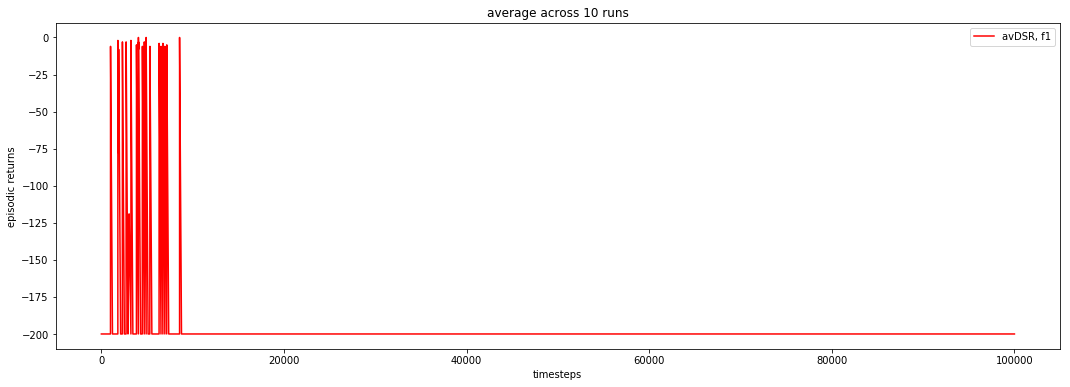

In [127]:
rewards_dict = {'avDSR, f1': r_avdsr1}
# plot_rewards(rewards_dict, plot_seperate=True, clip=2000)
plot_rewards(rewards_dict, plot_seperate=False, title='average across 10 runs')

### DSR base code

In [7]:
#######################################################################
# Copyright (C) 2017 Shangtong Zhang(zhangshangtong.cpp@gmail.com)    #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

"""
DQN code modified to convert it to DSR by Surya.
The representations are not learned in this network.
"""


class DSRActor(BaseActor):
    def __init__(self, config):
        BaseActor.__init__(self, config)
        self.config = config
        self.start()

    def _transition(self):
        if self._state is None:
            self._state = self._task.reset()
        config = self.config
        with config.lock:
            _, psi, q_values = self._network(config.state_normalizer(self._state))
        q_values = to_np(q_values).flatten()
        if self._total_steps < config.exploration_steps \
                or np.random.rand() < config.random_action_prob():
            action = np.random.randint(0, len(q_values))
        else:
            action = np.argmax(q_values)
        next_state, reward, done, info = self._task.step([action])
        
        entry = [self._state[0], action, reward[0], next_state[0], int(done[0]), info]
        self._total_steps += 1
        self._state = next_state
        return entry


class DSRAgent(BaseAgent):
    def __init__(self, config):
        BaseAgent.__init__(self, config)
        self.config = config
        config.lock = mp.Lock()
        
        self.loss_q_vec = []
        self.loss_psi_vec = []
        self.loss_vec = []
        self.returns = []

        self.replay = config.replay_fn()
        self.actor = DSRActor(config)

        self.network = config.network_fn()
        self.network.share_memory()
        self.target_network = config.network_fn()
        self.target_network.load_state_dict(self.network.state_dict())
        self.optimizer = config.optimizer_fn(self.network.parameters())
        self.w_optimizer = config.optimizer_fn(self.network.psi2q.parameters()) # only on w's

        self.actor.set_network(self.network)

        self.total_steps = 0
        self.batch_indices = range_tensor(self.replay.batch_size)

    def close(self):
        close_obj(self.replay)
        close_obj(self.actor)

    def eval_step(self, state):
        self.config.state_normalizer.set_read_only()
        state = self.config.state_normalizer(state)
        _, _, q = self.network(state)
        action = to_np(q.argmax(-1))
        self.config.state_normalizer.unset_read_only()
        return action

    def step(self):
        config = self.config

        # Store transitions in the buffer
        transitions = self.actor.step()
        experiences = []
        for state, action, reward, next_state, done, info in transitions:

            # Reporting training progress on stdout
            # self.record_online_return(info)
            
            # Recording train returns in list
            for i, info_ in enumerate(info):
                ret = info_['episodic_return']
                if ret is not None:
                    self.returns.append([self.total_steps, ret])
                    
            self.total_steps += 1
            reward = config.reward_normalizer(reward)

            # Putting these new entries in experiences
            experiences.append([state, action, reward, next_state, done])

        # Add experiences to replay
        self.replay.feed_batch(experiences)

        # Start updating network parameters after exploration_steps
        if self.total_steps > self.config.exploration_steps:

            # Sampling from replay buffer
            experiences = self.replay.sample()
            states, actions, rewards, next_states, terminals = experiences

            # Normalizing stat values
            states = self.config.state_normalizer(states)
            next_states = self.config.state_normalizer(next_states)

            # Computing targets
            _, psi_next, q_next = self.target_network(next_states)
            psi_next = psi_next.detach()
            q_next = q_next.detach()
            if self.config.double_q:
                best_actions = torch.argmax(self.network(next_states), dim=-1)
                q_next = q_next[self.batch_indices, best_actions]
            else:
                q_next = q_next.max(1) # predicts max q values (vector of b) and corresponding arguments
                a_star = q_next[1]
                q_next = q_next[0]
                psi_next = psi_next[self.batch_indices, a_star, :]

            terminals = tensor(terminals)
            rewards = tensor(rewards)

            # Estimate q target
            q_next = self.config.discount * q_next * (1 - terminals)
            q_next.add_(rewards)

            # Estimate psi target (obtained from target n/w) # CHECK: should we get target from network instead?
            psi_next = self.config.discount * psi_next * (1 - terminals.unsqueeze(1).repeat(1, psi_next.shape[1]))
            psi_next.add_(self.target_network(next_states)[0]) # Adding the prediction for present state.

            # Computing estimates
            actions = tensor(actions).long()
            _, psi, q = self.network(states)
            q = q[self.batch_indices, actions]
            psi = psi[self.batch_indices, actions, :]

            # Estimating the loss
            loss_q = (q_next - q).pow(2).mul(0.5).mean()
            loss_psi = config.c * (psi_next - psi).pow(2).mul(0.5).mean()
            loss = loss_q + loss_psi
            
            # Storing loss estimates
            self.loss_vec.append(loss.item())
            self.loss_q_vec.append(loss_q.item())
            self.loss_psi_vec.append(loss_psi.item())
            
            if(not np.isfinite(loss.item())):
                print(' loss has diverged!')
                import pdb;pdb.set_trace()
                return 
            
            # Update all
            self.optimizer.zero_grad()
            loss.backward(retain_graph=True)
            nn.utils.clip_grad_norm_(self.network.parameters(), self.config.gradient_clip)
            with config.lock:
                self.optimizer.step()
                
            # Update w parameters
#             self.w_optimizer.zero_grad()
#             loss_q.backward()
#             nn.utils.clip_grad_norm_(self.network.parameters(), self.config.gradient_clip)
#             with config.lock:
#                 self.w_optimizer.step()
                
            

        if self.total_steps / self.config.sgd_update_frequency % \
                self.config.target_network_update_freq == 0:
            self.target_network.load_state_dict(self.network.state_dict())

### DSR with seperate loss training

In [8]:
#######################################################################
# Copyright (C) 2017 Shangtong Zhang(zhangshangtong.cpp@gmail.com)    #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

"""
DQN code modified to convert it to DSR by Surya.
The representations are not learned in this network.
"""


class DSRActor(BaseActor):
    def __init__(self, config):
        BaseActor.__init__(self, config)
        self.config = config
        self.start()

    def _transition(self):
        if self._state is None:
            self._state = self._task.reset()
        config = self.config
        with config.lock:
            _, psi, q_values = self._network(config.state_normalizer(self._state))
        q_values = to_np(q_values).flatten()
        if self._total_steps < config.exploration_steps \
                or np.random.rand() < config.random_action_prob():
            action = np.random.randint(0, len(q_values))
        else:
            action = np.argmax(q_values)
        next_state, reward, done, info = self._task.step([action])
        
        entry = [self._state[0], action, reward[0], next_state[0], int(done[0]), info]
        self._total_steps += 1
        self._state = next_state
        return entry


class DSRAgent(BaseAgent):
    def __init__(self, config):
        BaseAgent.__init__(self, config)
        self.config = config
        config.lock = mp.Lock()
        
        self.loss_q_vec = []
        self.loss_psi_vec = []
        self.loss_vec = []
        self.returns = []

        self.replay = config.replay_fn()
        self.actor = DSRActor(config)

        self.network = config.network_fn()
        self.network.share_memory()
        self.target_network = config.network_fn()
        self.target_network.load_state_dict(self.network.state_dict())
        self.optimizer = config.optimizer_fn(self.network.parameters())
        self.w_optimizer = config.optimizer_fn(self.network.psi2q.parameters()) # only on w's

        self.actor.set_network(self.network)

        self.total_steps = 0
        self.batch_indices = range_tensor(self.replay.batch_size)

    def close(self):
        close_obj(self.replay)
        close_obj(self.actor)

    def eval_step(self, state):
        self.config.state_normalizer.set_read_only()
        state = self.config.state_normalizer(state)
        _, _, q = self.network(state)
        action = to_np(q.argmax(-1))
        self.config.state_normalizer.unset_read_only()
        return action

    def step(self):
        config = self.config

        # Store transitions in the buffer
        transitions = self.actor.step()
        experiences = []
        for state, action, reward, next_state, done, info in transitions:

            # Reporting training progress on stdout
            # self.record_online_return(info)
            
            # Recording train returns in list
            for i, info_ in enumerate(info):
                ret = info_['episodic_return']
                if ret is not None:
                    self.returns.append([self.total_steps, ret])
                    
            self.total_steps += 1
            reward = config.reward_normalizer(reward)

            # Putting these new entries in experiences
            experiences.append([state, action, reward, next_state, done])

        # Add experiences to replay
        self.replay.feed_batch(experiences)

        # Start updating network parameters after exploration_steps
        if self.total_steps > self.config.exploration_steps:

            # Sampling from replay buffer
            experiences = self.replay.sample()
            states, actions, rewards, next_states, terminals = experiences

            # Normalizing stat values
            states = self.config.state_normalizer(states)
            next_states = self.config.state_normalizer(next_states)

            # Computing targets
            _, psi_next, q_next = self.target_network(next_states)
            psi_next = psi_next.detach()
            q_next = q_next.detach()
            if self.config.double_q:
                best_actions = torch.argmax(self.network(next_states), dim=-1)
                q_next = q_next[self.batch_indices, best_actions]
            else:
                q_next = q_next.max(1) # predicts max q values (vector of b) and corresponding arguments
                a_star = q_next[1]
                q_next = q_next[0]
                psi_next = psi_next[self.batch_indices, a_star, :]

            terminals = tensor(terminals)
            rewards = tensor(rewards)

            # Estimate q target
            q_next = self.config.discount * q_next * (1 - terminals)
            q_next.add_(rewards)

            # Estimate psi target (obtained from target n/w) # CHECK: should we get target from network instead?
            psi_next = self.config.discount * psi_next * (1 - terminals.unsqueeze(1).repeat(1, psi_next.shape[1]))
            psi_next.add_(self.target_network(next_states)[0]) # Adding the prediction for present state.

            # Computing estimates
            actions = tensor(actions).long()
            _, psi, q = self.network(states)
            q = q[self.batch_indices, actions]
            psi = psi[self.batch_indices, actions, :]

            # Estimating the loss
            loss_q = (q_next - q).pow(2).mul(0.5).mean()
            loss_psi = config.c * (psi_next - psi).pow(2).mul(0.5).mean()
            loss = loss_q + loss_psi
            
            # Storing loss estimates
            self.loss_vec.append(loss.item())
            self.loss_q_vec.append(loss_q.item())
            self.loss_psi_vec.append(loss_psi.item())
            
            if(not np.isfinite(loss.item())):
                print(' loss has diverged!')
                import pdb;pdb.set_trace()
                return 
            
            # Update all except w
            self.optimizer.zero_grad()
            loss_psi.backward(retain_graph=True)
            nn.utils.clip_grad_norm_(self.network.parameters(), self.config.gradient_clip)
            with config.lock:
                self.optimizer.step()
                
            # Update w parameters
            self.w_optimizer.zero_grad()
            loss_q.backward()
            nn.utils.clip_grad_norm_(self.network.parameters(), self.config.gradient_clip)
            with config.lock:
                self.w_optimizer.step()
                
            

        if self.total_steps / self.config.sgd_update_frequency % \
                self.config.target_network_update_freq == 0:
            self.target_network.load_state_dict(self.network.state_dict())

### DSR main function

In [9]:
def dsr_feature(**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.c = 1
    config.freeze = False

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.001)
    config.network_fn = lambda: SRNet(config.action_dim, SRIdentityBody(config.state_dim))
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e4), batch_size=10)

    config.random_action_prob = LinearSchedule(1, 0.1, 1e3)
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = 1e4
    config.async_actor = False
    
    # Train an agent with the above config
    agent = DSRAgent(config)
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    while True:
        if config.save_interval and not agent.total_steps % config.save_interval:
            agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
        if config.log_interval and not agent.total_steps % config.log_interval:
#             agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.eval_interval and not agent.total_steps % config.eval_interval:
            agent.eval_episodes()
            pass
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
        agent.step()
        agent.switch_task()
        
    return agent

In [10]:
### Plotting the results
def convolve(points, kernelSize=5):
    array = np.convolve(points, np.ones(kernelSize), 'valid')
    return array

def plot_dqn(obj, title = 'DQN'):
    plt.figure(figsize=(12,12),dpi=100)
    plt.subplot(311)
    plt.plot(convolve(obj.loss_vec, kernelSize=11)/11)
    plt.title(title+' loss ')
    plt.ylabel('loss value'), plt.xlabel('batch no')
    plt.subplot(312)
    plt.plot(convolve(obj.loss_vec, kernelSize=111)/111)
    plt.title(title+' smoothed loss ')
    plt.ylabel('loss value'), plt.xlabel('batch no')
    plt.subplot(313)
    plt.plot(np.array(obj.returns)[:,0],np.array(obj.returns)[:,1])
    plt.xlabel('timesteps'), plt.ylabel('return')
    plt.title(title+' training performance')
    plt.show()

def plot_dsr(obj, title='DSR'):
    plt.figure(figsize=(12,12),dpi=100)
    plt.subplot(211)
    plt.plot(convolve(obj.loss_q_vec, kernelSize=11)/11)
    plt.title(title+' loss')
    plt.ylabel('loss q value'), plt.xlabel('batch no')
    plt.subplot(212)
    plt.plot(convolve(obj.loss_psi_vec, kernelSize=11)/11)
    plt.title(title+' loss')
    plt.ylabel('loss psi value'), plt.xlabel('batch no')
    
def plot_dsr2(obj, title='DSR'):
    plt.figure(figsize=(12,4),dpi=100)
    plt.plot(convolve(obj.loss_psi_vec, kernelSize=11)/11)
    plt.title(title+' loss')
    plt.ylabel('loss psi value'), plt.xlabel('batch no')

In [11]:
from deep_rl.component.lineworld import LineWorld
env = LineWorld()

def _visualize_vector(vector, title="unnamed", show_goal=False, show=True, label=""):
    plt.plot(vector, label=label)
    plt.title(title)
    if show:
        plt.legend()
        plt.show()
        
def sanity(agent):
    
    print(agent.network)
    
    # Setting things up
    env = LineWorld()
    
    # Visualize w
    w_vector = agent.network.state_dict()['psi2q.w'].numpy()
    _visualize_vector(w_vector, title="w learnt values")
    
    # Visualize psi
    states = [3]
    plt.figure(figsize=(len(states)*12, 5))
    
    for i, s in enumerate(states):
        temp = np.zeros(env.n)
        temp[s] = 1
        phi, psi, q = agent.network(tensor(temp).unsqueeze(0))
        psi = psi.detach().numpy()
        q = q.detach().numpy().flatten()
        _visualize_vector(psi[:,0,:].flatten(), title="q({},{})={}".format(s, 0, q[0]), show=False, label="0")
        _visualize_vector(psi[:,1,:].flatten(), title="psi estimates, s = {}".format(s), show=True, label="1")
            
    # Visualize policy
    state_space = np.identity(env.n)
    phi, psi, q = agent.network(tensor(state_space))
    optimal_actions = q.max(1)[1].detach().numpy()
#     import pdb; pdb.set_trace()
    _visualize_vector(optimal_actions, title='policy (0:left, 1:right)')

    plt.show()

### Run DSR agent

In [12]:
a = dsr_feature(game='LineWorld')

2020-04-16 13:04:19,204 - root - INFO: steps 0, episodic_return_test -3.00(0.00)
2020-04-16 13:04:28,043 - root - INFO: steps 5000, episodic_return_test -3.00(0.00)
2020-04-16 13:04:34,996 - root - INFO: steps 10000, episodic_return_test -3.00(0.00)


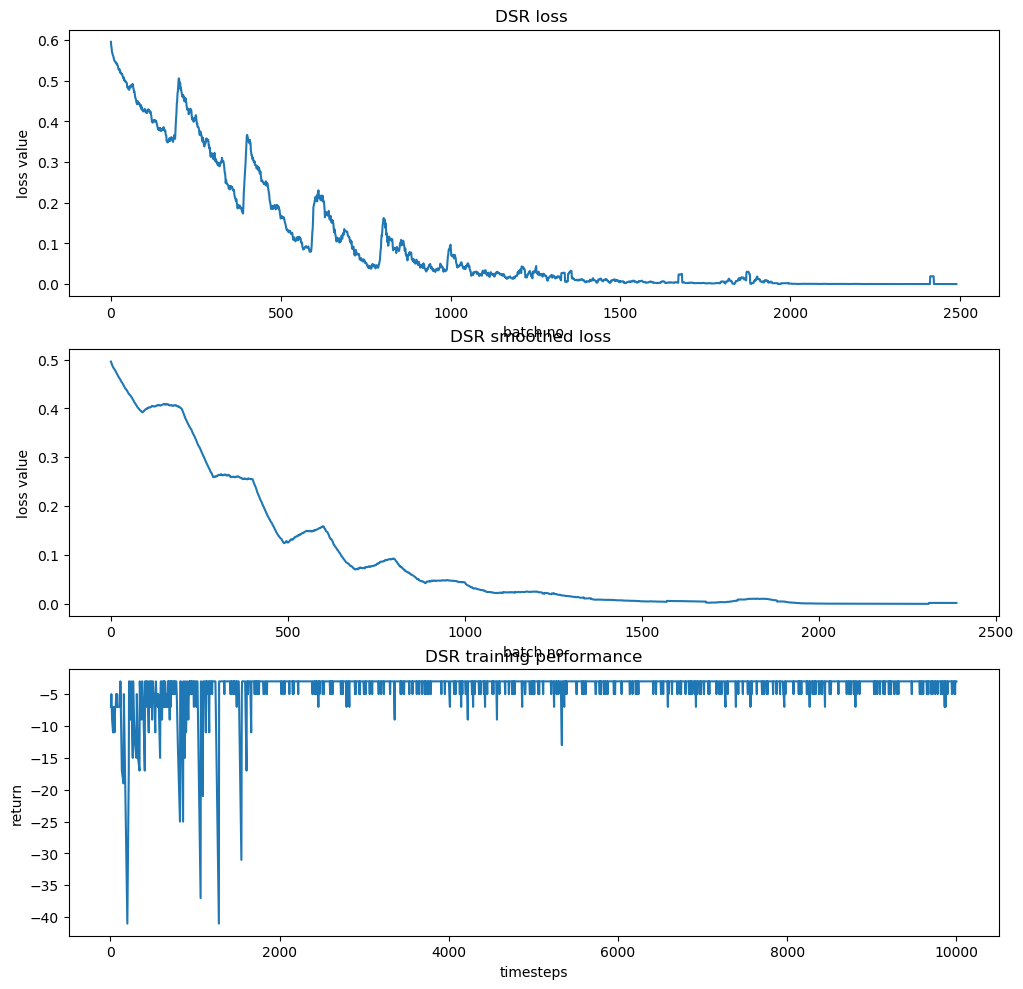

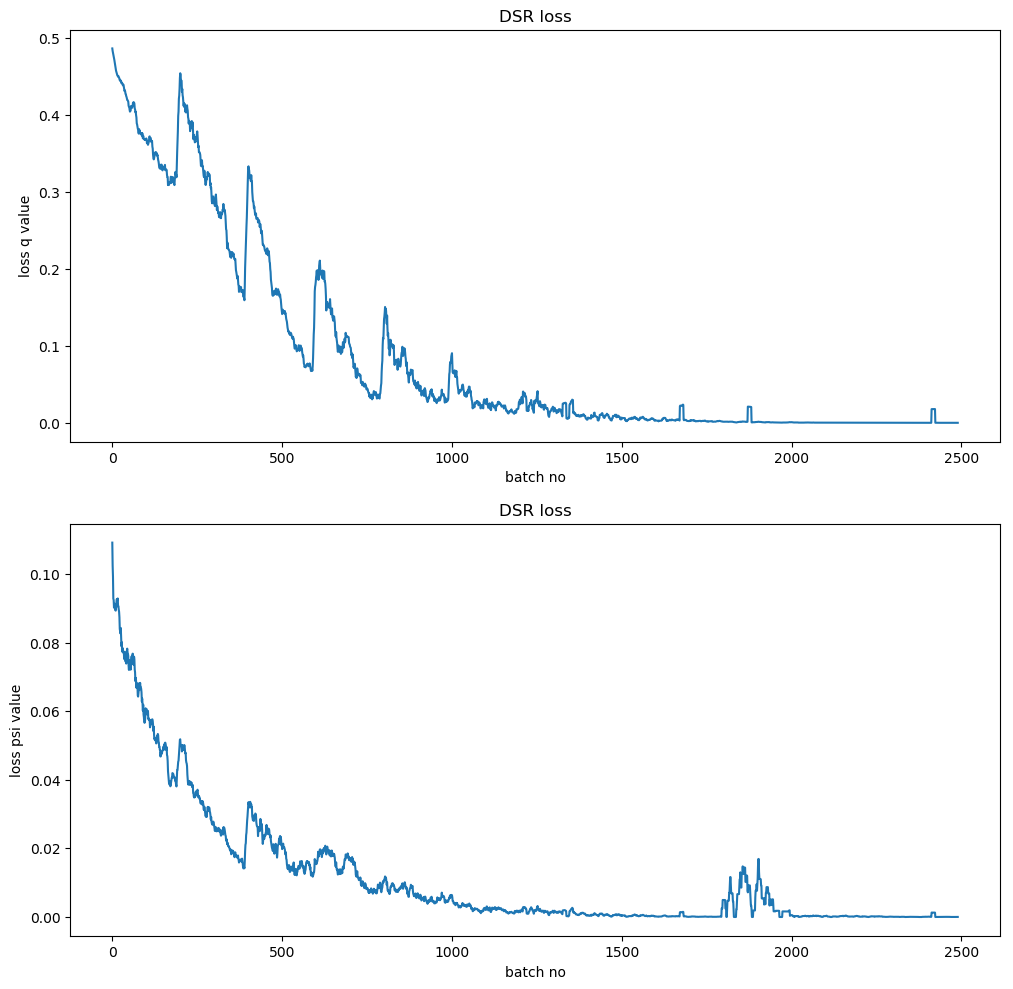

In [13]:
plot_dqn(a, title='DSR')
plot_dsr(a, title='DSR')

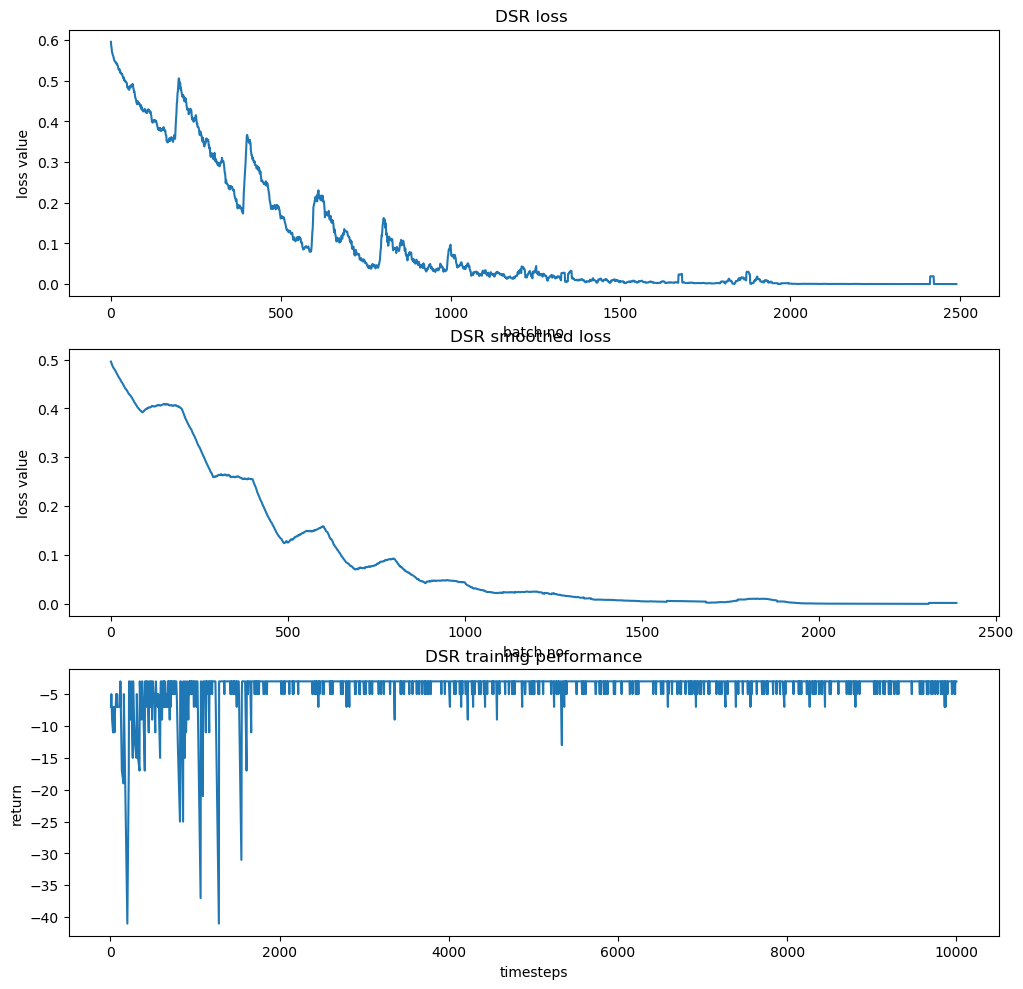

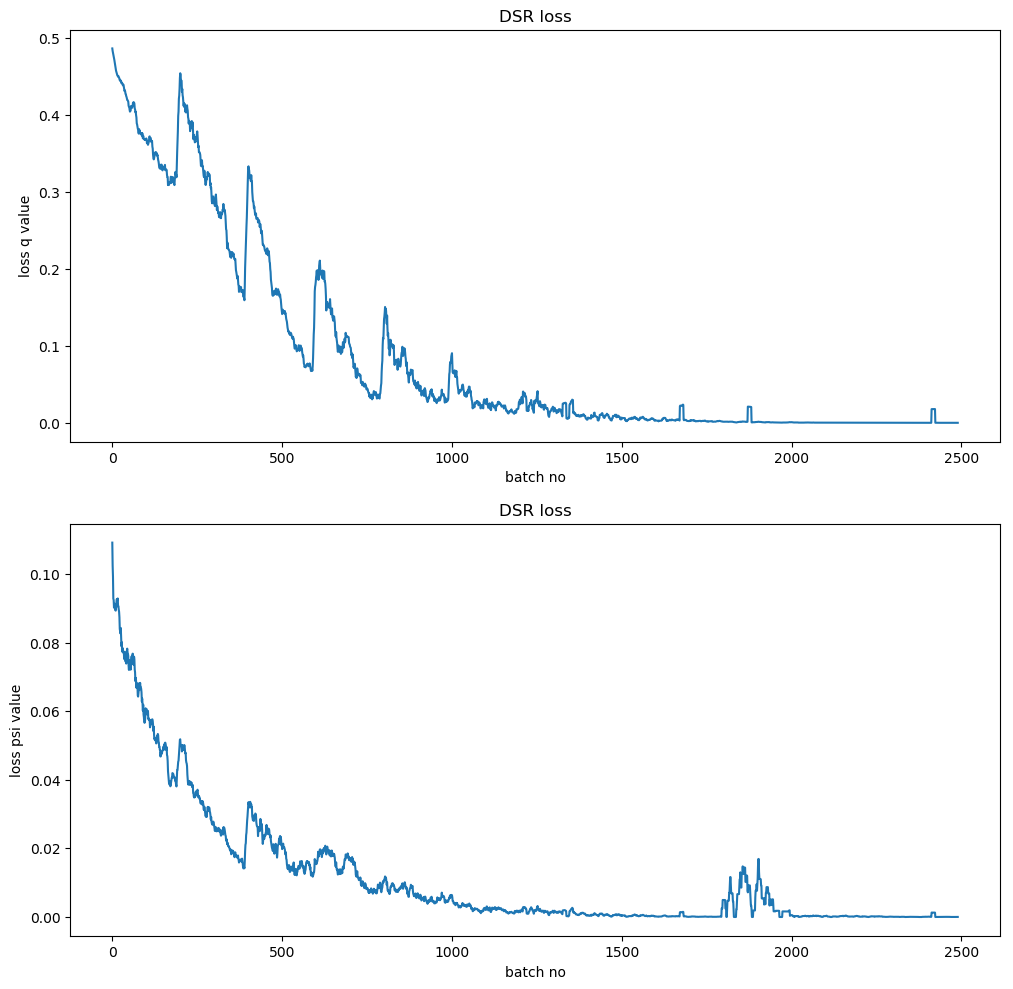

In [14]:
plot_dqn(a, title='DSR')
plot_dsr(a, title='DSR')

2020-04-16 13:04:39,457 - matplotlib.legend - WARNING: No handles with labels found to put in legend.


SRNet(
  (body): SRIdentityBody()
  (layers): ModuleList(
    (0): Linear(in_features=7, out_features=14, bias=True)
  )
  (psi2q): Psi2QNet()
)


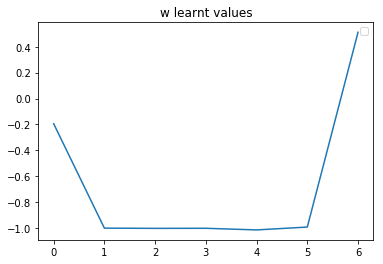

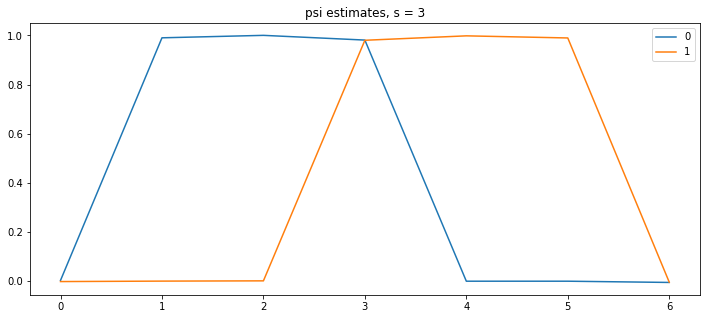

2020-04-16 13:04:40,336 - matplotlib.legend - WARNING: No handles with labels found to put in legend.


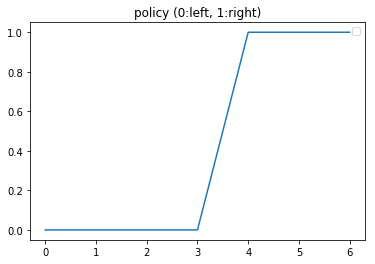

In [15]:
sanity(a)

### Run DQN agent

In [16]:
class DQNActor(BaseActor):
    def __init__(self, config):
        BaseActor.__init__(self, config)
        self.config = config
        self.start()

    def _transition(self):
        if self._state is None:
            self._state = self._task.reset()
        config = self.config
        with config.lock:
            q_values = self._network(config.state_normalizer(self._state))
        q_values = to_np(q_values).flatten()
        if self._total_steps < config.exploration_steps \
                or np.random.rand() < config.random_action_prob():
            action = np.random.randint(0, len(q_values))
        else:
            action = np.argmax(q_values)
        next_state, reward, done, info = self._task.step([action])
        entry = [self._state[0], action, reward[0], next_state[0], int(done[0]), info]
        self._total_steps += 1
        self._state = next_state
        return entry


class DQNAgent(BaseAgent):
    def __init__(self, config):
        BaseAgent.__init__(self, config)
        self.config = config
        config.lock = mp.Lock()

        self.returns = []
        
        self.replay = config.replay_fn()
        self.actor = DQNActor(config)

        self.network = config.network_fn()
        self.network.share_memory()
        self.target_network = config.network_fn()
        self.target_network.load_state_dict(self.network.state_dict())
        self.optimizer = config.optimizer_fn(self.network.parameters())
        self.loss_vec = []

        self.actor.set_network(self.network)

        self.total_steps = 0
        self.batch_indices = range_tensor(self.replay.batch_size)

    def close(self):
        close_obj(self.replay)
        close_obj(self.actor)

    def eval_step(self, state):
        self.config.state_normalizer.set_read_only()
        state = self.config.state_normalizer(state)
        q = self.network(state)
        action = to_np(q.argmax(-1))
        self.config.state_normalizer.unset_read_only()
        return action

    def step(self):
        config = self.config
        transitions = self.actor.step()
        experiences = []
        for state, action, reward, next_state, done, info in transitions:
#             self.record_online_return(info)
            
            # Recording train returns in list
            for i, info_ in enumerate(info):
                ret = info_['episodic_return']
                if ret is not None:
                    self.returns.append([self.total_steps, ret])
            
            self.total_steps += 1
            reward = config.reward_normalizer(reward)
            experiences.append([state, action, reward, next_state, done])
        self.replay.feed_batch(experiences)

        if self.total_steps > self.config.exploration_steps:
            experiences = self.replay.sample()
            states, actions, rewards, next_states, terminals = experiences
            states = self.config.state_normalizer(states)
            next_states = self.config.state_normalizer(next_states)
            q_next = self.target_network(next_states).detach()
            if self.config.double_q:
                best_actions = torch.argmax(self.network(next_states), dim=-1)
                q_next = q_next[self.batch_indices, best_actions]
            else:
                q_next = q_next.max(1)[0]
            terminals = tensor(terminals)
            rewards = tensor(rewards)
            q_next = self.config.discount * q_next * (1 - terminals)
            q_next.add_(rewards)
            actions = tensor(actions).long()
            q = self.network(states)
            q = q[self.batch_indices, actions]
            loss = (q_next - q).pow(2).mul(0.5).mean()
            self.loss_vec.append(loss.item())
            self.optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(self.network.parameters(), self.config.gradient_clip)
            with config.lock:
                self.optimizer.step()

        if self.total_steps / self.config.sgd_update_frequency % \
                self.config.target_network_update_freq == 0:
            self.target_network.load_state_dict(self.network.state_dict())

# DQN
def dqn_feature(**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.001)
    config.network_fn = lambda: VanillaNet(config.action_dim, FCBody(config.state_dim))
    # config.network_fn = lambda: DuelingNet(config.action_dim, FCBody(config.state_dim))
    # config.replay_fn = lambda: Replay(memory_size=int(1e4), batch_size=10)
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e4), batch_size=10)

    config.random_action_prob = LinearSchedule(1.0, 0.1, 1e3)
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = 1e4
    config.async_actor = False
    agent = DQNAgent(config)
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    while True:
        if config.save_interval and not agent.total_steps % config.save_interval:
            agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
        if config.log_interval and not agent.total_steps % config.log_interval:
#             agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.eval_interval and not agent.total_steps % config.eval_interval:
#             agent.eval_episodes()
            pass
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
#         import pdb; pdb.set_trace()
        agent.step()
        agent.switch_task()
    return agent

In [17]:
agent_dqn = dqn_feature(game='LineWorld')

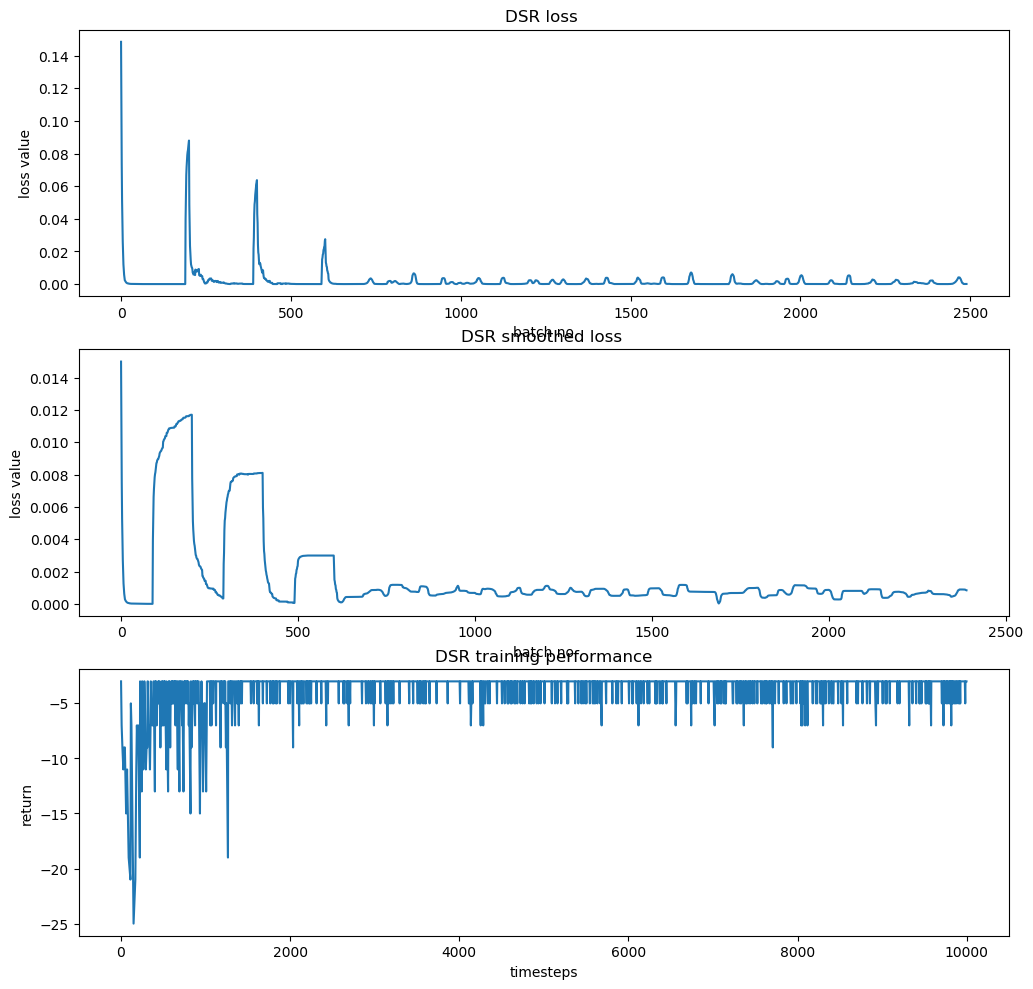

In [18]:
plot_dqn(agent_dqn, title='DSR')
# sanity(agent_dqn)

### Experiments on avSR

In [19]:
import random
"""
Code for learning the averageSR agent across good policies.
"""


class avDSRActor(BaseActor):
    def __init__(self, config, agents, style='DQN'):
        BaseActor.__init__(self, config)
        self.config = config
        self.agents = agents
        self.style = style
        self.start()

    def _transition(self):
        if self._state is None:
            self._state = self._task.reset()
        config = self.config
        

        # Choose one of the base agents randomly
        pick = random.choice(self.agents)

        # Find qvalues of the picked agent for the present state
        with config.lock:
            if(self.style == 'DSR'):
                _, _, q_values = pick.network(config.state_normalizer(self._state))
            else:
                q_values = pick.network(config.state_normalizer(self._state))
        q_values = to_np(q_values).flatten()

        # Take action based on this estimated q value
        if self._total_steps < config.exploration_steps \
                or np.random.rand() < config.random_action_prob():
            action = np.random.randint(0, len(q_values))
        else:
            action = np.argmax(q_values)
            
        next_state, reward, done, info = self._task.step([action])
        
        # Also estimate next action
        #############
        pick2 = random.choice(self.agents)
        with config.lock:
            if(self.style == 'DSR'):
                _, _, q_values = pick2.network(config.state_normalizer(next_state))
            else:
                q_values = pick2.network(config.state_normalizer(next_state))
        q_values = to_np(q_values).flatten()

        if self._total_steps < config.exploration_steps \
                or np.random.rand() < config.random_action_prob():
            next_action = np.random.randint(0, len(q_values))
        else:
            next_action = np.argmax(q_values)
        
        entry = [self._state[0], action, reward[0], next_state[0], next_action, int(done[0]), info]
        self._total_steps += 1
        self._state = next_state
        return entry


class avDSRAgent(BaseAgent):
    def __init__(self, config, agents, style='DQN'):
        """
        agents -> list of agents whose actions we need to consider.
        """
        BaseAgent.__init__(self, config)
        self.config = config
        config.lock = mp.Lock()
        
        self.loss_q_vec = []
        self.loss_psi_vec = []
        self.loss_vec = []

        self.replay = config.replay_fn()
        self.actor = avDSRActor(config, agents, style)

        self.network = config.network_fn()
        self.network.share_memory()
        self.optimizer = config.optimizer_fn(self.network.parameters())

        self.actor.set_network(self.network)

        self.total_steps = 0
        self.batch_indices = range_tensor(self.replay.batch_size) # Need to make this size bigger

    def close(self):
        close_obj(self.replay)
        close_obj(self.actor)

    def eval_step(self, state):
        self.config.state_normalizer.set_read_only()
        state = self.config.state_normalizer(state)
        _, _, q = self.network(state)
        action = to_np(q.argmax(-1))
        self.config.state_normalizer.unset_read_only()
        return action

    def step(self):
        config = self.config

        # Store transitions in the buffer
        transitions = self.actor.step()
        experiences = []
        for state, action, reward, next_state, next_action, done, info in transitions:
#             self.record_online_return(info)
            self.total_steps += 1
            reward = config.reward_normalizer(reward)
            experiences.append([state, action, reward, next_state, next_action, done])
        self.replay.feed_batch(experiences)

        # Start updating network parameters after exploration_steps
        if self.total_steps > self.config.exploration_steps:

            # Getting samples from buffer
            experiences = self.replay.sample()
            states, actions, rewards, next_states, next_actions, terminals = experiences
            states = self.config.state_normalizer(states)
            next_states = self.config.state_normalizer(next_states)

            # Estimate targets
            with torch.no_grad():
                _, psi_next, _ = self.network(next_states)
            psi_next = psi_next.detach()
            if self.config.double_q:
                best_actions = torch.argmax(self.network(next_states), dim=-1)
                q_next = q_next[self.batch_indices, best_actions]
            else:
                next_actions = tensor(next_actions).long()
                psi_next = psi_next[self.batch_indices, next_actions, :] # TODO: double check dims here

            terminals = tensor(terminals)
            psi_next = self.config.discount * psi_next * (1 - terminals.unsqueeze(1).repeat(1, psi_next.shape[1]))
            psi_next.add_(self.network(states)[0]) # TODO: double chec this
            # Computing estimates
            actions = tensor(actions).long()
            _, psi, _ = self.network(states)
            psi = psi[self.batch_indices, actions, :]
            
            
#             loss_psi = (psi_next - psi).pow(2).mul(0.5).mean(0)
            loss_psi = (psi_next - psi).pow(2).mul(0.5).mean()

            loss = loss_psi
            
            total_loss = loss.mean()
            self.loss_vec.append(total_loss.item())
            self.loss_psi_vec.append(total_loss.item())
            
            
            self.optimizer.zero_grad()
#             loss.backward(torch.ones(loss.shape))
            loss.backward()

            nn.utils.clip_grad_norm_(self.network.parameters(), self.config.gradient_clip)

            with config.lock:
                self.optimizer.step()


In [20]:
def avDSR(**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.c = 1

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.001)
#     config.optimizer_fn = lambda params: torch.optim.SGD(params, lr=0.001)

    config.network_fn = lambda: SRNet_backup(config.action_dim, SRIdentityBody(config.state_dim))
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e4), batch_size=10)

    config.random_action_prob = LinearSchedule(0.1, 0.1, 1e4) # CHECK
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.max_steps = 1e4
    config.async_actor = False
    
    agent = avDSRAgent(config, config.agents)
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    while True:
        if config.log_interval and not agent.total_steps % config.log_interval:
            agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
        agent.step()
        agent.switch_task()

In [21]:
agent_k1 = avDSR(game='LineWorld', agents=[a])
agent_k2 = avDSR(game='LineWorld', agents=[a])

NameError: name 'SRNet_backup' is not defined

In [ ]:
plot_dsr2(agent_k1, 'avDSR prediction')
plot_dsr2(agent_k2, 'avDSR prediction')

### Train new agent with avDSR initialization

In [ ]:
def dsr_feature_init(ref,**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.c = 10

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.001)
    config.network_fn = lambda: SRNet_backup(config.action_dim, SRIdentityBody(config.state_dim))
#     config.network_fn = lambda: SRNet(config.action_dim, SRIdentityBody(config.state_dim), \
#                         Phi2Psi(config.state_dim, config.action_dim, hidden_units=(104,)))
    # config.network_fn = lambda: DuelingNet(config.action_dim, FCBody(config.state_dim))
    # config.replay_fn = lambda: Replay(memory_size=int(1e4), batch_size=10)
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e4), batch_size=10)

    config.random_action_prob = LinearSchedule(1.0, 0.1, 1e3)
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = 1e4
    config.async_actor = False
    
    agent = DSRAgent(config)
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    if(ref is not None):
        agent.network.load_state_dict(ref.network.state_dict())
    t0 = time.time()
    while True:
        if config.save_interval and not agent.total_steps % config.save_interval:
            agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
        if config.log_interval and not agent.total_steps % config.log_interval:
#             agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.eval_interval and not agent.total_steps % config.eval_interval:
            agent.eval_episodes()
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
        agent.step()
        agent.switch_task()
        
    return agent

In [ ]:
from tqdm import trange, tqdm
r_vec_av = []; t_vec_av = []
for i in trange(5, desc='runs'): 
    agent_f = dsr_feature_init(ref=agent_k1, game='LineWorld')
    rewards = np.array(agent_f.returns)
    t_vec_av.append(rewards[:,0])
    r_vec_av.append(rewards[:,1])

In [ ]:
r_vec_dsr = []; t_vec_dsr = []
for i in trange(5, desc='runs'): 
    agent_dsr = dsr_feature(game='LineWorld')
    rewards = np.array(agent_dsr.returns)
    t_vec_dsr.append(rewards[:,0])
    r_vec_dsr.append(rewards[:,1])

In [ ]:
r_vec_dqn = []; t_vec_dqn = []
for i in trange(5, desc='runs'): 
    agent_dqn = dqn_feature(game='LineWorld')
    rewards = np.array(agent_dqn.returns)
    t_vec_dqn.append(rewards[:,0])
    r_vec_dqn.append(rewards[:,1])

In [ ]:
def plot_rewards(rewards, plot_seperate=True , clip=10000):
    
    colors = ['red', 'blue', 'green', '#999999']
    
    plt.figure(figsize=(18,6))
    if(plot_seperate):
        for k, v in rewards.items():
            for t, r in zip(v[0], v[1]):
                plt.plot(t, r, label=k)
        plt.legend(), plt.show()
        return
    
    for j, (k, v) in enumerate(rewards.items()):
        r_vec = np.zeros((len(v[0]), clip))
        for i, (t, r) in enumerate(zip(v[0], v[1])):
            r_vec[i,:] = np.interp(np.arange(clip), t, r)
    
        mean = np.mean(np.array(r_vec), axis=0)
        std = np.std(np.array(r_vec), axis=0)
        plt.plot(mean, label=k, color=colors[j])
        plt.fill_between(np.arange(0, len(mean)), mean+std, mean-std, facecolor=colors[j], alpha=0.3)
    
    plt.legend(), plt.show()

In [ ]:
rewards_dict = {'avInit': (t_vec_av, r_vec_av),
              'DSR': (t_vec_dsr, r_vec_dsr),
               'DQN': (t_vec_dqn, r_vec_dqn)}
plot_rewards(rewards_dict, plot_seperate=False, clip=2000)